The goal is to build a CNN model using PyTorch that classifies cats and dogs images. The dataset is based on <a href='https://www.kaggle.com/c/dogs-vs-cats'>this Kaggle competition</a>.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# define transforms
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
# prepare train and test sets, loaders
root = './CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


Label: [1 1 0 0 1 1 0 1 0 0]
Class: DOG DOG CAT CAT DOG DOG CAT DOG CAT CAT


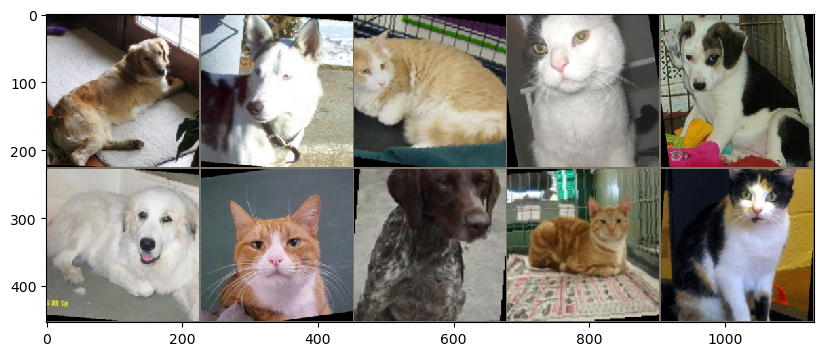

In [4]:
# display a batch of images
# grab the first batch of 10 images
for images,labels in train_loader: 
    break

# print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)

# inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [5]:
# define the model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [9]:
# define loss function and optimizer
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [10]:
# train the model
import time
start_time = time.time()

epochs = 3

max_train_batch = 800
max_test_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # limit the number of batches
        if b == max_train_batch:
            break
        b+=1
        
        # apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {train_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(train_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_test_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.60821176  accuracy:  57.650%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.81295317  accuracy:  59.600%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.52314937  accuracy:  61.667%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.65138739  accuracy:  62.763%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.42884797  accuracy:  68.100%
epoch:  1  batch:  400 [  4000/8000]  loss: 0.62603509  accuracy:  69.000%
epoch:  1  batch:  600 [  6000/8000]  loss: 0.53353393  accuracy:  69.817%
epoch:  1  batch:  800 [  8000/8000]  loss: 0.50802118  accuracy:  70.188%
epoch:  2  batch:  200 [  2000/8000]  loss: 0.46499342  accuracy:  71.950%
epoch:  2  batch:  400 [  4000/8000]  loss: 0.27674547  accuracy:  73.225%
epoch:  2  batch:  600 [  6000/8000]  loss: 0.92999327  accuracy:  73.467%
epoch:  2  batch:  800 [  8000/8000]  loss: 0.38625163  accuracy:  73.725%

Duration: 699 seconds


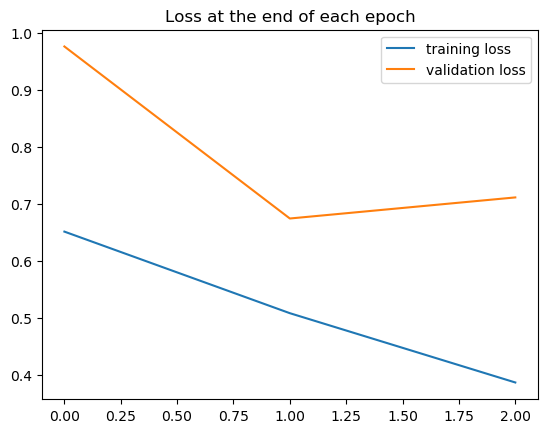

In [12]:
# evaluate the model
plt.plot([i.item() for i in train_losses], label='training loss')
plt.plot([i.item() for i in test_losses], label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

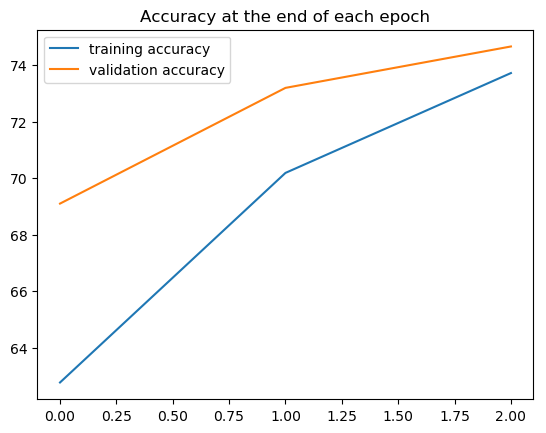

In [13]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [14]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2073), tensor(2196), tensor(2240)]
Test accuracy: 74.667%


In [23]:
# use the pretrained model
AlexNetmodel = models.alexnet(pretrained=True)

In [24]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
# freeze feature parameters
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [26]:
# modify the fully connected layers to produce a binary output
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [27]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [28]:
# train the model, only the fully connected layers
# the convolutional layers have fixed weights and biases, so we only need to run one epoch
import time
start_time = time.time()

epochs = 1

max_train_batch = 800
max_test_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_train_batch:
            break
        b+=1
        
        # apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {train_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(train_corr)

    # run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_test_batch:
                break

            # apply the model
            y_val = AlexNetmodel(X_test)

            # tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.07556047  accuracy:  88.300%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.00515757  accuracy:  91.200%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.35067356  accuracy:  92.050%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.01618453  accuracy:  92.537%

Duration: 280 seconds


In [29]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2841)]
Test accuracy: 94.700%


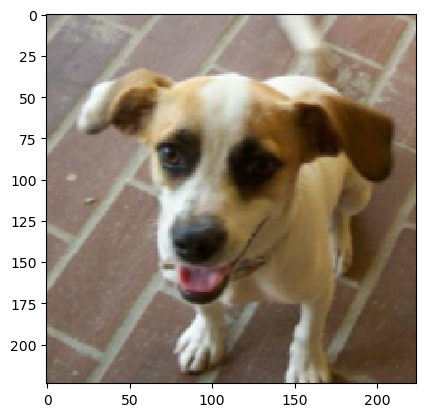

In [39]:
# run a new image through the model
# pick an index from 0 to 6250
x = 5000
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [40]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [41]:
# CNN prediction:

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG


In [42]:
# AlexNet prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 1 DOG
